In [228]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stateModel = np.array([(0, 0, 0.10), \
                      (0.05, 0.10, 0.70), \
                      (0.15, 0.80, 0.15), \
                      (0.70, 0.10, 0.05), \
                      (0.10, 0, 0)])

stateLabels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]

measurementLabels = ["HALLWAY", "WALL", "OPEN DOOR", "CLOSED DOOR", "NOTHING"]

measurementProbabilities = np.array([[0.65, 0.10, 0.20, 0.05], \
                                    [0.05, 0.45, 0.10, 0.20], \
                                    [0.20, 0.10, 0.50, 0.15], \
                                    [0.05, 0.30, 0.15, 0.55], \
                                    [0.05, 0.05, 0.05, 0.05]])

measurementModel = pd.DataFrame(measurementProbabilities, \
                                index=measurementLabels, \
                                columns=measurementLabels[:-1])
stateMap = {"A": "WALL", \
            "B": "HALLWAY", \
            "C": "WALL", \
            "D": "CLOSED DOOR", \
            "E": "WALL", \
            "F": "OPEN DOOR", \
            "G": "WALL", \
            "H": "CLOSED DOOR", \
            "I": "WALL", \
            "J": "HALLWAY"}

In [86]:
print(measurementModel)

             HALLWAY  WALL  OPEN DOOR  CLOSED DOOR
HALLWAY         0.65  0.10       0.20         0.05
WALL            0.05  0.45       0.10         0.20
OPEN DOOR       0.20  0.10       0.50         0.15
CLOSED DOOR     0.05  0.30       0.15         0.55
NOTHING         0.05  0.05       0.05         0.05


In [214]:
initialBelief = pd.Series((1, 0, 0, 0, 0, 0, 0, 0, 0, 0), index=stateLabels)
print(initialization)

A    1
B    0
C    0
D    0
E    0
F    0
G    0
H    0
I    0
J    0
dtype: int64


In [308]:
def addPadding(stateProbabilities, amountOfPadding=5, paddingNum=0):
    padding = pd.Series([paddingNum]*amountOfPadding)
    paddedStateProbabilities = padding.append(stateProbabilities).append(padding)
    return paddedStateProbabilities

In [309]:
def removePadding(paddedStateProbabilities, amountOfPadding=5):
    stateProbabilities = paddedStateProbabilities[amountOfPadding:-amountOfPadding]
    return stateProbabilities

In [340]:
def mapStateToMeasurements(stateMap, measurementModel, measurement):
    states = sorted(stateMap.keys())
    measurementStateProbabilities = pd.Series()
    for state in states:
        measurementStateProbabilities[state] = measurementModel[measurement][stateMap[state]]
    return measurementStateProbabilities
        

In [375]:
def predictState(currentProbabilities, stateModel, controlInput):
    controlIndex = controlInput + 1
    predict = lambda window: np.multiply(window, stateModel[-window.size:,controlIndex]).sum()
    statePredictions = currentProbabilities.rolling(stateModel.shape[0], center=True, min_periods=3).apply(statePrediction)
    
    normalizationConstant = 1/statePredictions.sum()
    statePredictions *= normalizationConstant
    
    return statePredictions

In [376]:
def updateState(priorStateProbabilities, measurementStateProbabilities):
    stateUpdate = np.multiply(priorStateProbabilities, measurementStateProbabilities)
    
    normalizationConstant = 1/stateUpdate.sum()
    stateUpdate *= normalizationConstant
    return stateUpdate

In [377]:
def stepForward(stateMap, currentProbabilities, stateModel, \
                controlSignal, measurement, measurementModel, \
                defaultLocation):
    
    paddedCurrentProbabilities = addPadding(currentProbabilities)
    priorStateProbabilities = predictState(paddedCurrentProbabilities, \
                                           stateModel, controlSignal)
    
    measurementStateProbabilities = mapStateToMeasurements(stateMap, \
                                                           measurementModel, measurement)
    paddedMeasurementStateProbabilities = addPadding(measurementStateProbabilities, \
                                                     paddingNum=measurementModel[measurement][defaultLocation])
    
    posteriorStateProbabilities = updateState(priorStateProbabilities, \
                                              paddedMeasurementStateProbabilities)
    
    priorStateProbabilities = removePadding(priorStateProbabilities)
    posteriorStateProbabilities = removePadding(posteriorStateProbabilities)
    states = currentProbabilities.index
    
    stepLabels = ["Current", "Control", "Prediction", "Measurement", "Update"]
    stepSummary = pd.concat([currentProbabilities, \
                             pd.Series(controlSignal, index=states), \
                             priorStateProbabilities, \
                             pd.Series(measurement, index=states), \
                             posteriorStateProbabilities], \
                             axis=1)
    
    stepSummary.columns = stepLabels
    
    return stepSummary
        

In [379]:
controlSignalHistory = pd.Series((1, 1, 1, 0, 1, 1, 1, 1, 1, np.nan))
measurementHistory = pd.Series((np.nan, "HALLWAY", "WALL", "WALL", \
                                "CLOSED DOOR", "WALL", "WALL", \
                                "OPEN DOOR", "WALL", "CLOSED DOOR"))
robotHistory = pd.concat((controlSignalHistory, measurementHistory), axis=1)
robotHistory.columns = ["Control", "Measurement"]


In [380]:
print(robotHistory)

   Control  Measurement
0      1.0          NaN
1      1.0      HALLWAY
2      1.0         WALL
3      0.0         WALL
4      1.0  CLOSED DOOR
5      1.0         WALL
6      1.0         WALL
7      1.0    OPEN DOOR
8      1.0         WALL
9      NaN  CLOSED DOOR


In [381]:
def generateMultiIndex(step, states):
    associations = []
    for state in states:
        associations.append((step, state))
    index = pd.MultiIndex.from_tuples(associations, names=['k', 'state'])
    print(index)
    return index
    

In [394]:
def bayesianEstimator(robotHistory, initialBelief, stateMap, stateModel, measurementModel, defaultLocation):
    stateEvolution = list()
    currentBelief = initialBelief
    states = initialBelief.index
    for step in robotHistory.index[:-1]:
        #index = generateMultiIndex(step, states)
        controlSignal = robotHistory.iloc[step]["Control"]
        measurement = robotHistory.iloc[step + 1]["Measurement"]
        stepPredictions = stepForward(stateMap, currentBelief, stateModel, controlSignal, measurement, measurementModel, defaultLocation)
        stepPredictions.index = states
        stepPredictions.index.name = "State"
        currentBelief = stepPredictions["Update"]
        stateEvolution.append(stepPredictions)
    return stateEvolution

In [384]:
stateEvolution = bayesianEstimator(robotHistory, initialBelief, stateMap, stateModel, measurementModel, "WALL")

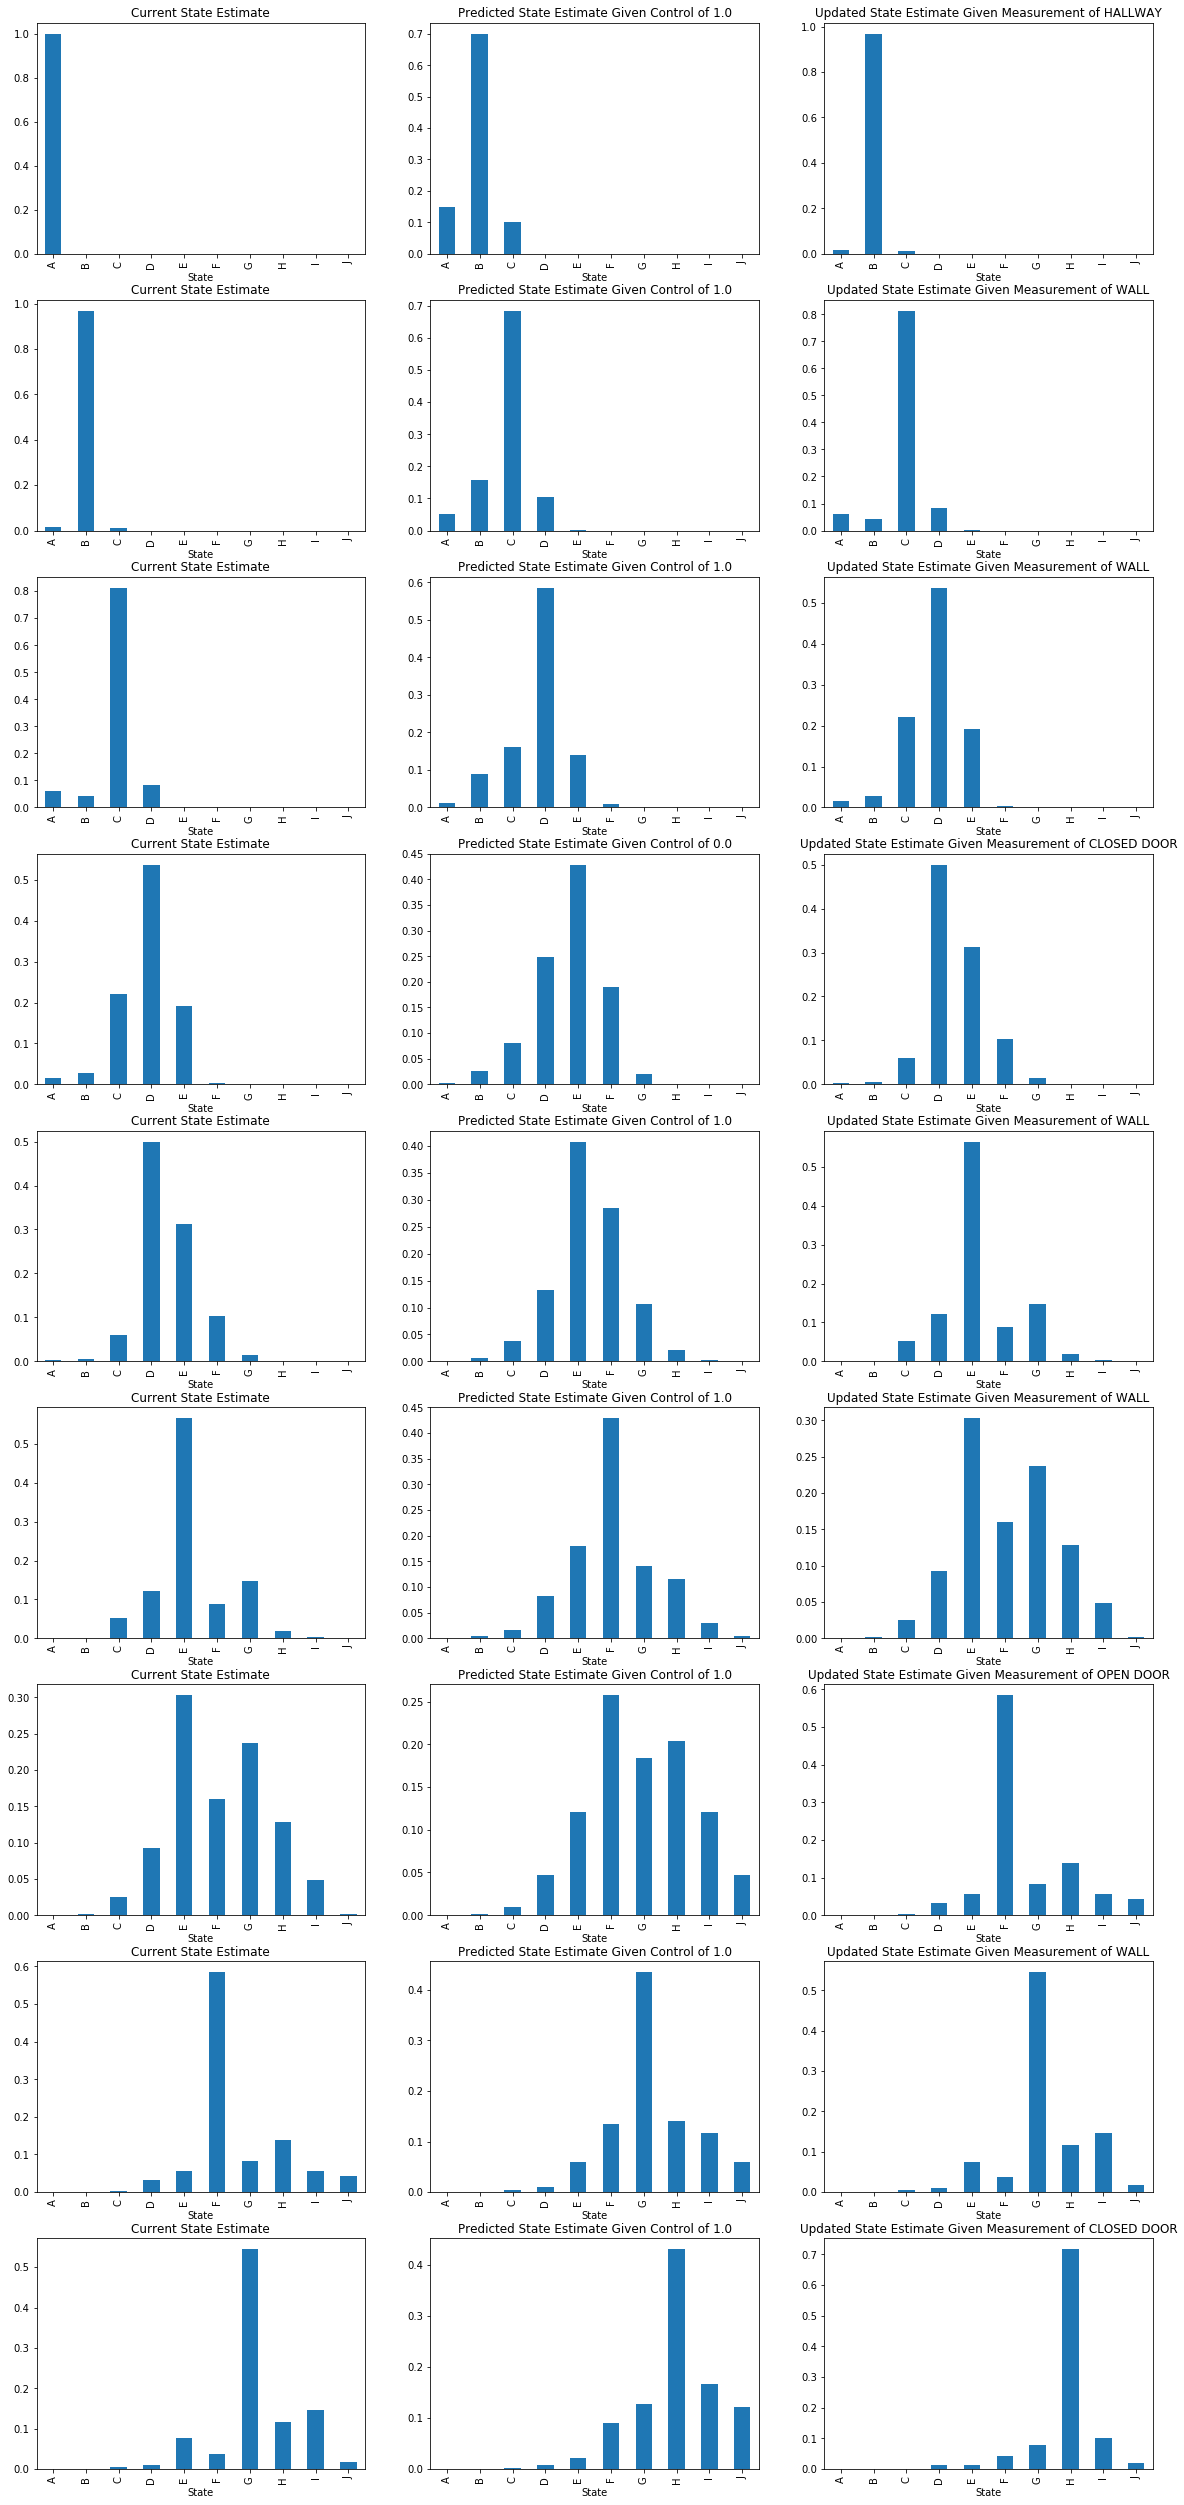

In [418]:
%matplotlib inline
fig, axes = plt.subplots(nrows=9, ncols=3)
figsize = (20, 45)
for step, stateSummary in enumerate(stateEvolution):
    stateSummary["Current"].plot(ax=axes[step,0],kind='bar', figsize=figsize, title="Current State Estimate")
    stateSummary["Prediction"].plot(ax=axes[step,1], kind='bar', figsize=figsize, title="Predicted State Estimate Given Control of {}".format(stateSummary["Control"][0]))
    stateSummary["Update"].plot(ax=axes[step,2], kind='bar', figsize=figsize, title="Updated State Estimate Given Measurement of {}".format(stateSummary["Measurement"][0]))
    

0.98239280621546